<a href="https://colab.research.google.com/github/pra08528/PRODIGY_GA_05/blob/main/code_neural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
from PIL import Image
from io import BytesIO

def download_image_as_jpeg(url, save_path):
    try:
        # Download image from URL
        response = requests.get(url)
        response.raise_for_status()


        img = Image.open(BytesIO(response.content))

        # Convert image to RGB (necessary for saving as JPEG)
        img = img.convert('RGB')

        # Save image as JPEG
        img.save(save_path, 'JPEG')
        print(f"Image saved as JPEG to {save_path}")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading image: {e}")
    except Exception as e:
        print(f"Error saving image: {e}")

# Replace with a direct image URL from Pexels or another source
image_url = 'https://images.pexels.com/photos/3048527/pexels-photo-3048527.png?auto=compress&cs=tinysrgb&w=600'
save_path = 'downloaded_image.jpg'

download_image_as_jpeg(image_url, save_path)


Image saved as JPEG to downloaded_image.jpg


In [ ]:
import requests
from PIL import Image
from io import BytesIO

def download_image_as_jpeg(url, save_path):
    try:

        response = requests.get(url)
        response.raise_for_status()


        img = Image.open(BytesIO(response.content))


        img = img.convert('RGB')


        img.save(save_path, 'JPEG')
        print(f"Image saved as JPEG to {save_path}")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading image: {e}")
    except Exception as e:
        print(f"Error saving image: {e}")


image_url = 'https://images.pexels.com/photos/1087735/pexels-photo-1087735.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1'
save_path = 'downloaded1_image.jpg'

download_image_as_jpeg(image_url, save_path)


Image saved as JPEG to downloaded1_image.jpg


In [ ]:
pip install torch torchvision pillow


In [ ]:
import torch
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


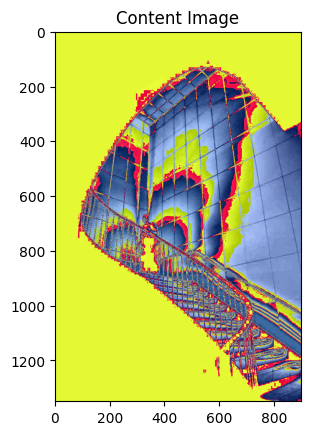

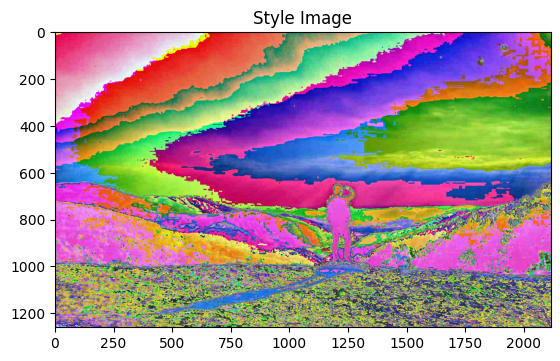

In [ ]:
# Image loading function
def load_image(image_path, max_size=400):
    image = Image.open(image_path)
    size = max(max(image.size), max_size)
    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))])

    image = in_transform(image)[:3, :, :].unsqueeze(0)
    return image.to(device)

# Paths to your content and style images
content_image = load_image('downloaded_image.jpg')
style_image = load_image('downloaded1_image.jpg')

# Display function
def imshow(tensor, title=None):
    image = tensor.cpu().clone().detach().squeeze(0)
    image = transforms.ToPILImage()(image)
    if title is not None:
        plt.title(title)
    plt.imshow(image)
    plt.show()

imshow(content_image, title='Content Image')
imshow(style_image, title='Style Image')


In [ ]:
# Load the pre-trained VGG19 model
vgg = models.vgg19(pretrained=True).features.to(device).eval()

# Freeze model parameters
for param in vgg.parameters():
    param.requires_grad_(False)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Define layers to extract content and style features
def get_features(image, model, layers=None):
    if layers is None:
        layers = {
            '0': 'conv1_1',
            '5': 'conv2_1',
            '10': 'conv3_1',
            '19': 'conv4_1',
            '21': 'conv4_2',  # Content layer
            '28': 'conv5_1'
        }

    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features

content_features = get_features(content_image, vgg)
style_features = get_features(style_image, vgg)


In [ ]:
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}


Step 0, Total loss: 4.0256776569041715e+17


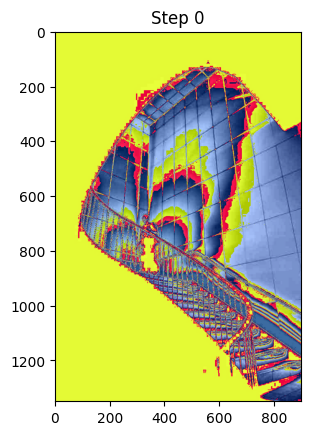

In [ ]:
# Create a target image to optimize (start with content image)
target = content_image.clone().requires_grad_(True).to(device)

# Define weights for content and style loss
style_weights = {'conv1_1': 1.0, 'conv2_1': 0.75, 'conv3_1': 0.2,
                 'conv4_1': 0.2, 'conv5_1': 0.2}
content_weight = 1  # alpha
style_weight = 1e6  # beta

# Define optimizer
optimizer = optim.Adam([target], lr=0.003)

# Run the style transfer
steps = 2000  # Number of iterations
for step in range(steps):
    target_features = get_features(target, vgg)

    # Content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)

    # Style loss
    style_loss = 0
    for layer in style_weights:
        target_gram = gram_matrix(target_features[layer])
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)
        style_loss += layer_style_loss

    # Total loss
    total_loss = content_weight * content_loss + style_weight * style_loss

    # Backpropagation
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # Display the target image every 500 steps
    if step % 500 == 0:
        print(f"Step {step}, Total loss: {total_loss.item()}")
        imshow(target, title=f'Step {step}')


In [ ]:
# Display the final stylized image
imshow(target, title='Final Stylized Image')
